## Using Machine Learning to Forecast Energy Consumption


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

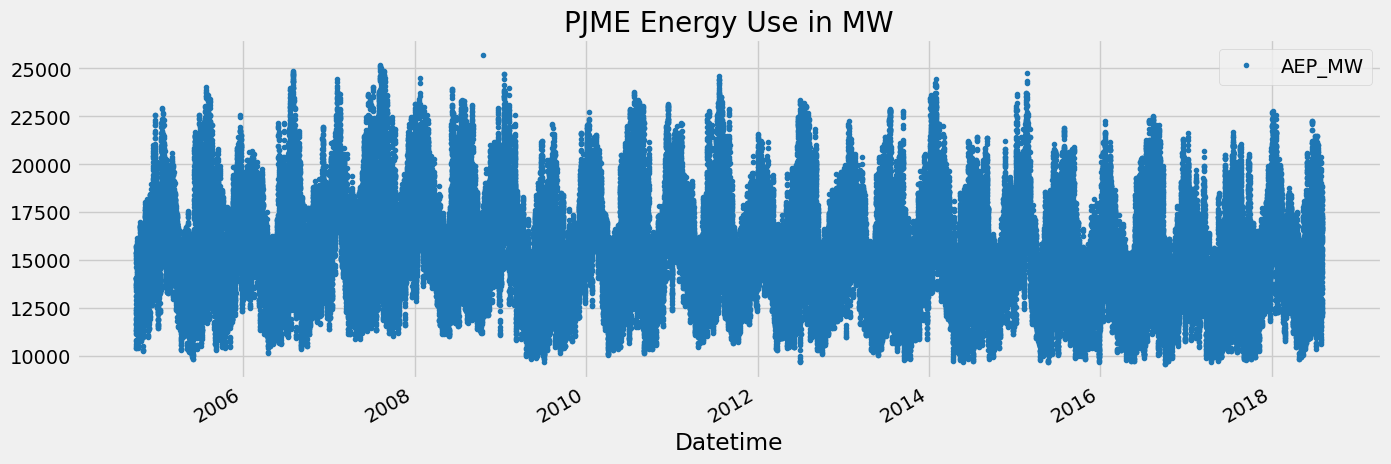

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

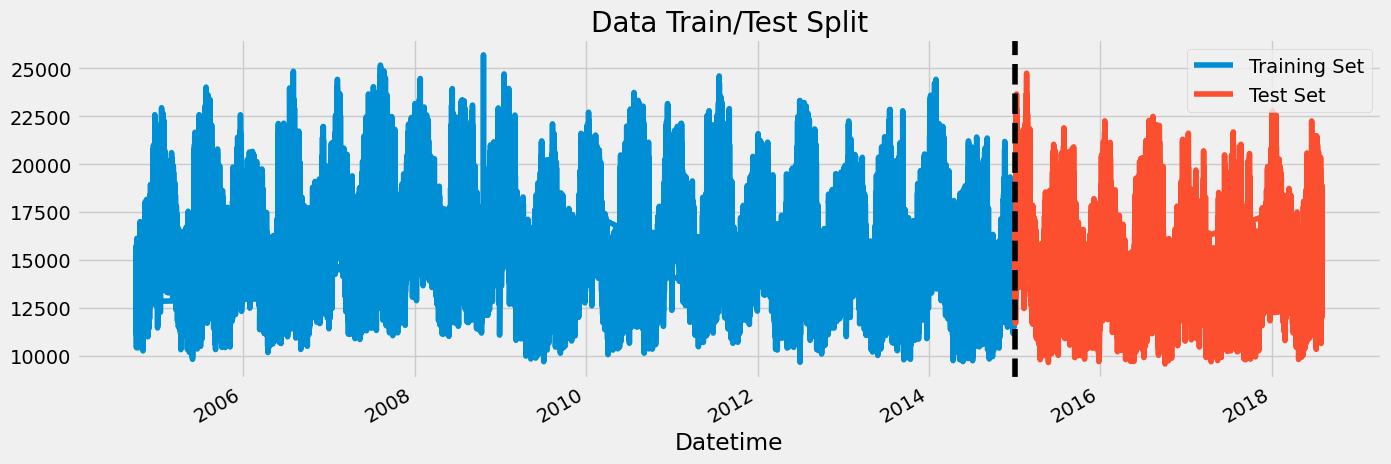

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

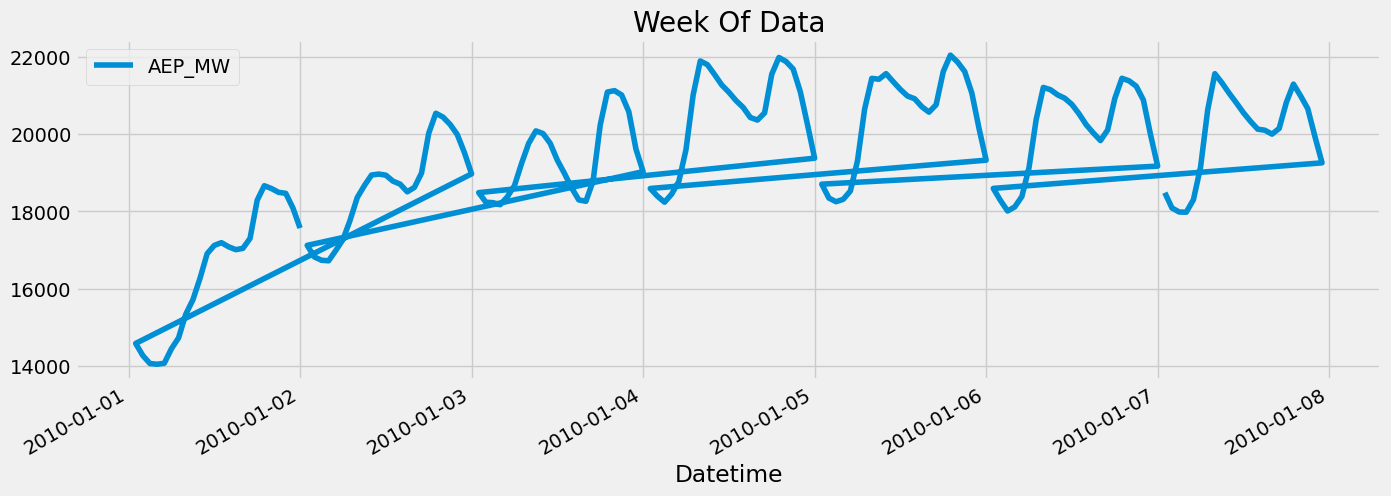

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

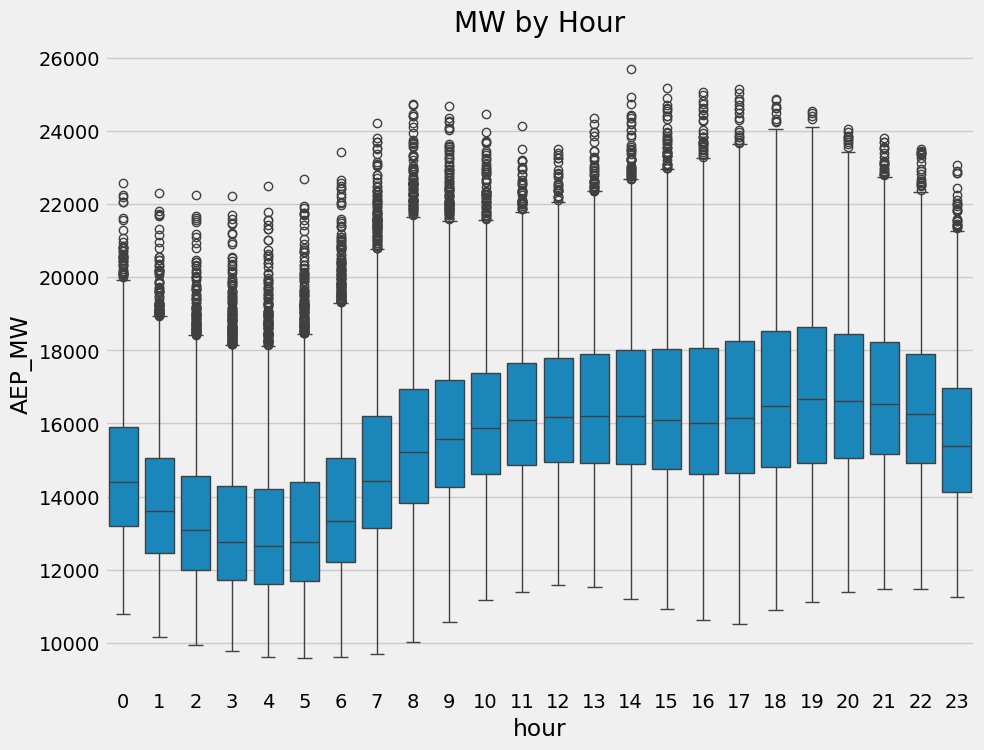

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_31292\3087536141.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


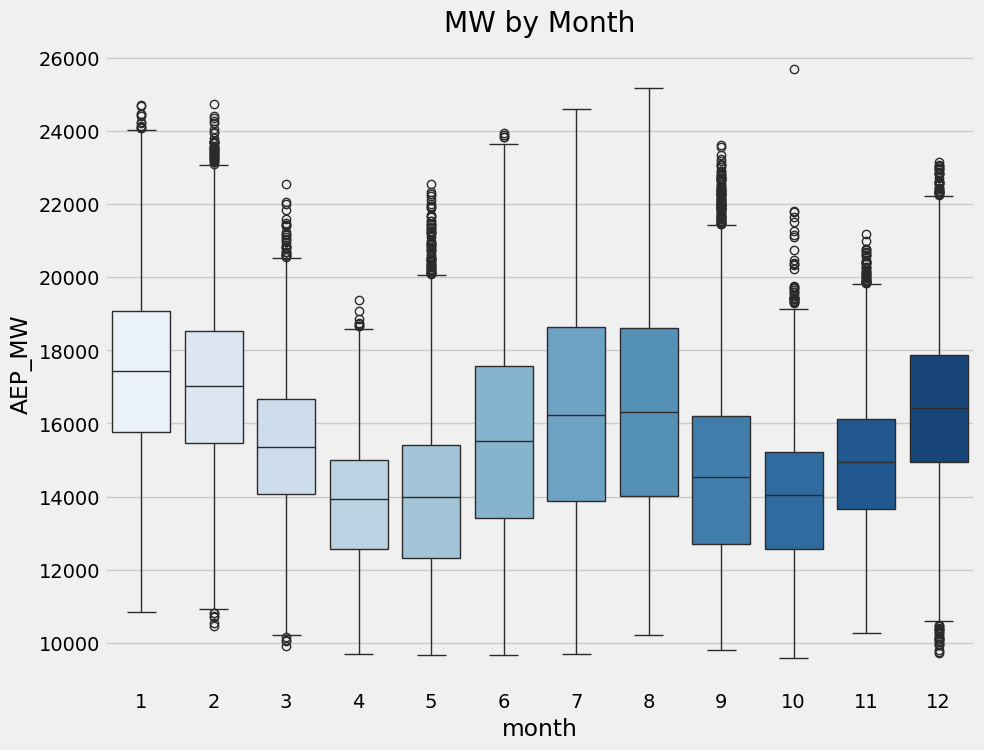

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15793.26088	validation_1-rmse:14861.30012


f:\bda-project\env\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:6033.92025	validation_1-rmse:5144.77002
[200]	validation_0-rmse:2703.71020	validation_1-rmse:2159.54200
[200]	validation_0-rmse:2703.71020	validation_1-rmse:2159.54200
[300]	validation_0-rmse:1754.92809	validation_1-rmse:1667.43143
[300]	validation_0-rmse:1754.92809	validation_1-rmse:1667.43143
[393]	validation_0-rmse:1525.95027	validation_1-rmse:1657.89627
[393]	validation_0-rmse:1525.95027	validation_1-rmse:1657.89627


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


# Feature Importance

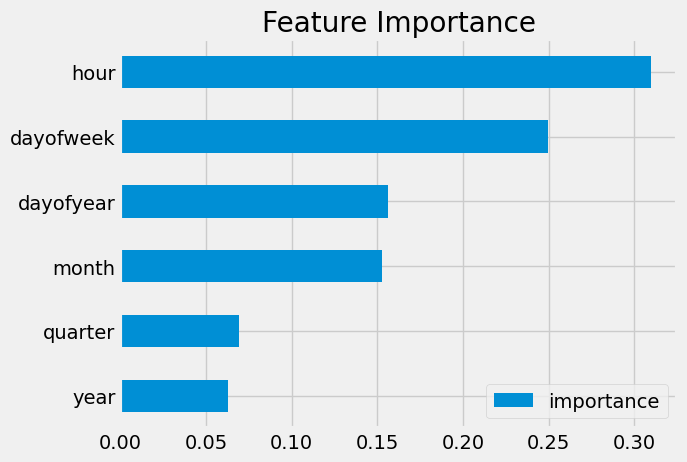

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

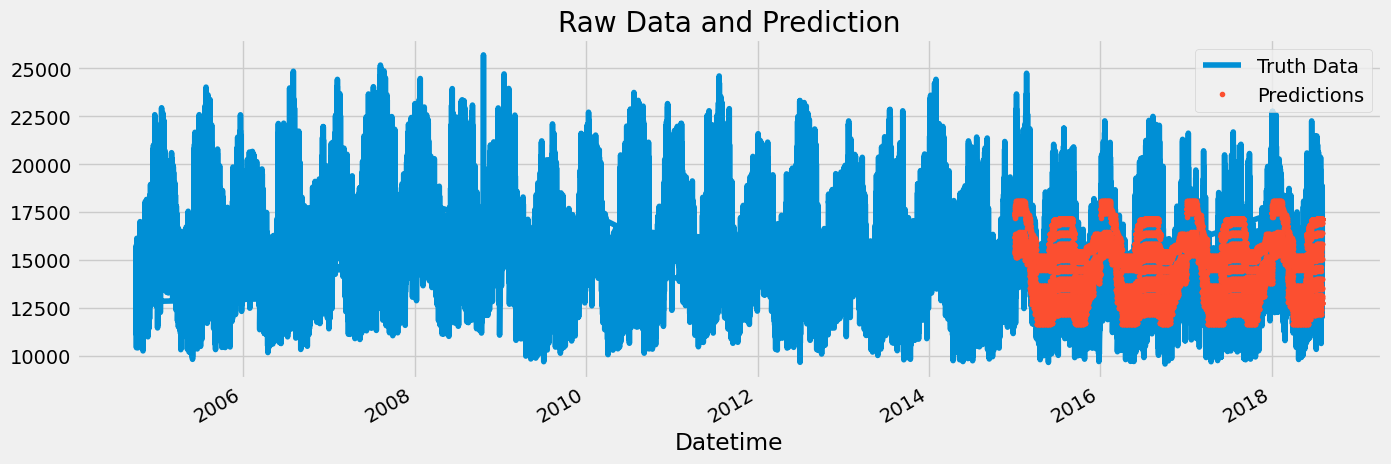

In [14]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

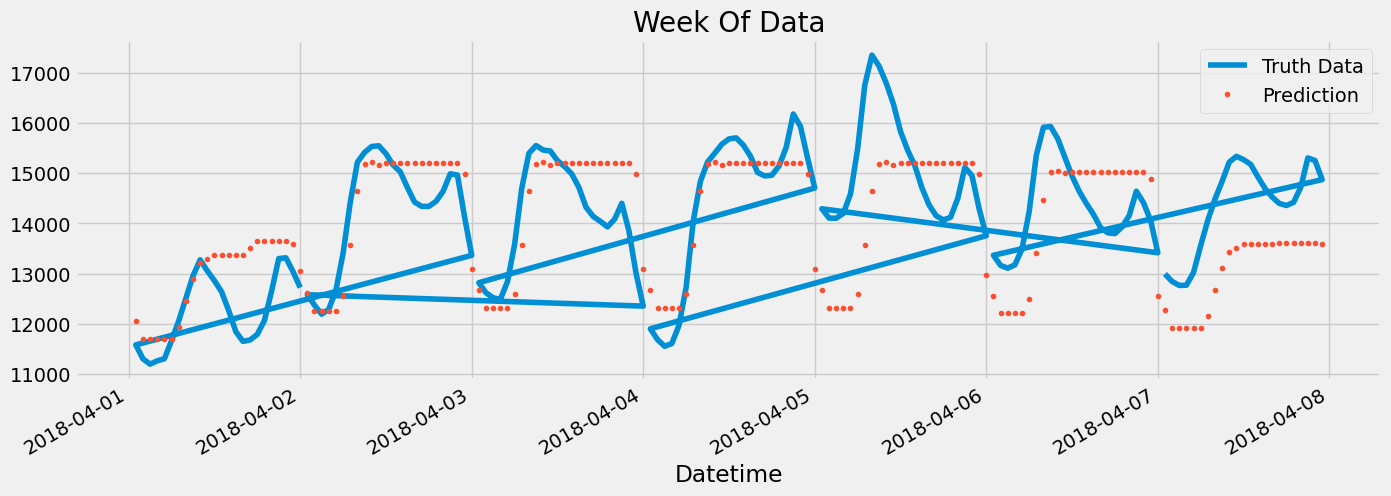

In [15]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [16]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1649.42


# Calculate Error
- Look at the worst and best predicted days

In [18]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5630.352132
2015-02-20    5394.673665
2018-01-06    4823.354574
2015-01-08    4703.830404
2015-12-25    4415.192912
2015-02-16    4411.147461
2015-12-24    4138.202759
2015-02-15    4079.741536
2018-01-05    4044.314657
2018-01-07    4037.638062
Name: error, dtype: float64

# The End

# Model Serialization for Deployment

In [19]:
import pickle
import joblib
import os
from datetime import datetime

# Create models directory
os.makedirs('../models', exist_ok=True)

print("Creating pickle files for deployment...")

Creating pickle files for deployment...


In [20]:
# Save the trained model
with open('../models/energy_model.pkl', 'wb') as f:
    pickle.dump(reg, f)
print("✅ Model saved as energy_model.pkl")

# Save feature engineering function
with open('../models/create_features.pkl', 'wb') as f:
    pickle.dump(create_features, f)
print("✅ Feature function saved as create_features.pkl")

# Save model configuration
model_config = {
    'features': FEATURES,
    'target': TARGET,
    'model_params': {
        'n_estimators': 1000,
        'max_depth': 3,
        'learning_rate': 0.01
    },
    'performance': {
        'rmse': float(score)
    },
    'feature_importance': dict(zip(FEATURES, reg.feature_importances_)),
    'created_date': datetime.now().isoformat()
}

with open('../models/model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✅ Model config saved as model_config.pkl")

print(f"Model RMSE: {score:.2f}")

✅ Model saved as energy_model.pkl
✅ Feature function saved as create_features.pkl
✅ Model config saved as model_config.pkl
Model RMSE: 1649.42
